In [19]:
# Import necessary libraries
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.nn import Sequential, Linear
from torch_geometric.nn import NNConv
import torch.nn.functional as F
from tqdm import tqdm

In [20]:
# %% Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [21]:
# %% Load data from MATLAB files
num_instances = 1000
data_list = []

for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    # Extract positions and signal strength
    node_latitudes = mat_data['nodeLatitudes'].flatten()
    node_longitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    # Number of nodes
    num_nodes = len(node_latitudes)

    # Create truth locations (latitude and longitude converted to x, y coordinates)
    truth_location_list = np.column_stack((node_latitudes, node_longitudes))

    # Compute distances and create edge attributes
    edge_index_list = []
    edge_attr_list = []

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                edge_attr_list.append(signal_strength_matrix[i, j, :])  # Use all 10 simulated measurements
    
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Create node features
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:4] = True  # First 1 nodes are anchors
    unknown_mask = ~anchor_mask

    # Node features: coordinates and anchor flag (1 for anchor, 0 for unknown)
    node_features = []
    # for i in range(num_nodes):
    #     is_anchor = 1 if i < 1 else 0
    #     node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])
    # Node features: coordinates (anchors only) and anchor flag (1 for anchor, 0 for unknown)
    for i in range(num_nodes):
        is_anchor = 1 if i < 4 else 0  # Adjust if your anchors are not the first 4 nodes
        if is_anchor:
            node_features.append([node_latitudes[i], node_longitudes[i], is_anchor])
        else:
            # Initialize unknown nodes' positions with zeros
            node_features.append([0.0, 0.0, is_anchor])


    x = torch.tensor(node_features, dtype=torch.float)

    # Labels (ground truth positions)
    y = torch.tensor(truth_location_list, dtype=torch.float)

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    data_list.append(data)

Loading MATLAB data: 100%|██████████| 1000/1000 [00:00<00:00, 1185.18it/s]


In [22]:
# # %% Normalize features using StandardScaler
# all_features = torch.cat([data.x for data in data_list], dim=0).numpy()
# scaler = StandardScaler()
# scaler.fit(all_features)

# for data in data_list:
#     data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)
# Collect features from anchor nodes only for fitting the scaler
all_anchor_features = torch.cat([data.x[data.anchor_mask] for data in data_list], dim=0).numpy()
scaler = StandardScaler()
scaler.fit(all_anchor_features)

# Apply the scaler to all data
for data in data_list:
    data.x = torch.tensor(scaler.transform(data.x.numpy()), dtype=torch.float)

# %% Create DataLoader
train_loader = DataLoader(data_list, batch_size=2, shuffle=True)

C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [23]:
# %% Define GCN model
class EdgeFeatureNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(EdgeFeatureNet, self).__init__()
        self.net = Sequential(
            Linear(input_dim, 64),
            torch.nn.ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, edge_feature_dim, num_measurements):
        super(GCN, self).__init__()
        # Edge feature network to process time-series edge attributes
        self.edge_net = EdgeFeatureNet(num_measurements, edge_feature_dim)
        
        # Edge networks for NNConv layers
        nn1 = Sequential(Linear(edge_feature_dim, hidden_dim * input_dim))
        self.conv1 = NNConv(input_dim, hidden_dim, nn1, aggr='mean')
        
        nn2 = Sequential(Linear(edge_feature_dim, hidden_dim * hidden_dim))
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2, aggr='mean')
        
        self.fc = Linear(hidden_dim, output_dim)
        
        # Projection layers for anchor nodes
        self.anchor_proj1 = Linear(input_dim, hidden_dim)
        self.anchor_proj2 = Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, edge_index, edge_attr, anchor_mask):
        # Process edge attributes using EdgeFeatureNet
        edge_attr_processed = self.edge_net(edge_attr)
        
        # Save the original features of anchor nodes
        x_anchor = x[anchor_mask]
        
        # First GNN layer
        x = self.conv1(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj1(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the projected anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Save the features of anchor nodes after the first layer
        x_anchor = x[anchor_mask]
        
        # Second GNN layer
        x = self.conv2(x, edge_index, edge_attr_processed)
        x = F.relu(x)
        
        # Project anchor nodes' features to match the hidden dimension
        x_anchor_proj = self.anchor_proj2(x_anchor)
        
        # Create a full-sized tensor for x_anchor_proj
        x_anchor_proj_full = x.clone()
        x_anchor_proj_full[anchor_mask] = x_anchor_proj
        
        # Combine the anchor features with the updated features
        x = torch.where(anchor_mask.unsqueeze(1), x_anchor_proj_full, x)
        
        # Final fully connected layer
        x = self.fc(x)
        return x

In [24]:
# %% Instantiate model and optimizer
input_dim = data_list[0].x.shape[1]  # Adjust input dimension based on node features
hidden_dim = 64  # Adjust as needed
output_dim = 2   # Predicting x and y coordinates
edge_feature_dim = 32  # Adjust as needed

model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, edge_feature_dim=edge_feature_dim, num_measurements=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


In [25]:
# %% Training loop
model.train()
loss_history = []

for epoch in range(50):
    total_loss = 0

    for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)

        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

Training Epoch 1: 100%|██████████| 500/500 [00:02<00:00, 184.12it/s]


Epoch 1, Loss: 331957255696.1622


Training Epoch 2: 100%|██████████| 500/500 [00:02<00:00, 192.51it/s]


Epoch 2, Loss: 615453.3268


Training Epoch 3: 100%|██████████| 500/500 [00:02<00:00, 190.21it/s]


Epoch 3, Loss: 884425.8159


Training Epoch 4: 100%|██████████| 500/500 [00:02<00:00, 191.68it/s]


Epoch 4, Loss: 395126.5464


Training Epoch 5: 100%|██████████| 500/500 [00:02<00:00, 192.83it/s]


Epoch 5, Loss: 138684.8751


Training Epoch 6: 100%|██████████| 500/500 [00:02<00:00, 193.08it/s]


Epoch 6, Loss: 40327164342.3915


Training Epoch 7: 100%|██████████| 500/500 [00:02<00:00, 193.38it/s]


Epoch 7, Loss: 21437.7884


Training Epoch 8: 100%|██████████| 500/500 [00:02<00:00, 187.79it/s]


Epoch 8, Loss: 5768.5146


Training Epoch 9: 100%|██████████| 500/500 [00:02<00:00, 181.54it/s]


Epoch 9, Loss: 3685.6848


Training Epoch 10: 100%|██████████| 500/500 [00:02<00:00, 195.25it/s]


Epoch 10, Loss: 4073.4003


Training Epoch 11: 100%|██████████| 500/500 [00:03<00:00, 161.82it/s]


Epoch 11, Loss: 4306.2791


Training Epoch 12: 100%|██████████| 500/500 [00:03<00:00, 138.22it/s]


Epoch 12, Loss: 7275.2446


Training Epoch 13: 100%|██████████| 500/500 [00:03<00:00, 136.32it/s]


Epoch 13, Loss: 99149.8723


Training Epoch 14: 100%|██████████| 500/500 [00:03<00:00, 140.11it/s]


Epoch 14, Loss: 18966.2954


Training Epoch 15: 100%|██████████| 500/500 [00:03<00:00, 140.52it/s]


Epoch 15, Loss: 91477.0111


Training Epoch 16: 100%|██████████| 500/500 [00:03<00:00, 138.55it/s]


Epoch 16, Loss: 38419.4528


Training Epoch 17: 100%|██████████| 500/500 [00:03<00:00, 140.69it/s]


Epoch 17, Loss: 142800.5021


Training Epoch 18: 100%|██████████| 500/500 [00:03<00:00, 142.55it/s]


Epoch 18, Loss: 1560.8912


Training Epoch 19: 100%|██████████| 500/500 [00:03<00:00, 143.56it/s]


Epoch 19, Loss: 1544.6732


Training Epoch 20: 100%|██████████| 500/500 [00:03<00:00, 143.48it/s]


Epoch 20, Loss: 2082.4521


Training Epoch 21: 100%|██████████| 500/500 [00:03<00:00, 143.26it/s]


Epoch 21, Loss: 7420.1159


Training Epoch 22: 100%|██████████| 500/500 [00:03<00:00, 142.83it/s]


Epoch 22, Loss: 6606.8978


Training Epoch 23: 100%|██████████| 500/500 [00:03<00:00, 141.54it/s]


Epoch 23, Loss: 11261.5184


Training Epoch 24: 100%|██████████| 500/500 [00:03<00:00, 140.51it/s]


Epoch 24, Loss: 3326.7916


Training Epoch 25: 100%|██████████| 500/500 [00:03<00:00, 139.73it/s]


Epoch 25, Loss: 3029.8921


Training Epoch 26: 100%|██████████| 500/500 [00:03<00:00, 142.82it/s]


Epoch 26, Loss: 1365.0678


Training Epoch 27: 100%|██████████| 500/500 [00:03<00:00, 145.05it/s]


Epoch 27, Loss: 2384.7041


Training Epoch 28: 100%|██████████| 500/500 [00:03<00:00, 144.00it/s]


Epoch 28, Loss: 1102.2333


Training Epoch 29: 100%|██████████| 500/500 [00:03<00:00, 144.62it/s]


Epoch 29, Loss: 620.3624


Training Epoch 30: 100%|██████████| 500/500 [00:03<00:00, 143.85it/s]


Epoch 30, Loss: 570.3390


Training Epoch 31: 100%|██████████| 500/500 [00:03<00:00, 142.67it/s]


Epoch 31, Loss: 267.3585


Training Epoch 32: 100%|██████████| 500/500 [00:03<00:00, 142.58it/s]


Epoch 32, Loss: 427.8283


Training Epoch 33: 100%|██████████| 500/500 [00:03<00:00, 141.99it/s]


Epoch 33, Loss: 327.0139


Training Epoch 34: 100%|██████████| 500/500 [00:03<00:00, 142.83it/s]


Epoch 34, Loss: 311.8622


Training Epoch 35: 100%|██████████| 500/500 [00:03<00:00, 143.23it/s]


Epoch 35, Loss: 220.6188


Training Epoch 36: 100%|██████████| 500/500 [00:03<00:00, 144.08it/s]


Epoch 36, Loss: 155.5876


Training Epoch 37: 100%|██████████| 500/500 [00:03<00:00, 141.26it/s]


Epoch 37, Loss: 348.8494


Training Epoch 38: 100%|██████████| 500/500 [00:03<00:00, 142.92it/s]


Epoch 38, Loss: 333.5043


Training Epoch 39: 100%|██████████| 500/500 [00:03<00:00, 144.92it/s]


Epoch 39, Loss: 60.4304


Training Epoch 40: 100%|██████████| 500/500 [00:03<00:00, 142.22it/s]


Epoch 40, Loss: 710.2463


Training Epoch 41: 100%|██████████| 500/500 [00:03<00:00, 142.09it/s]


Epoch 41, Loss: 0.2885


Training Epoch 42: 100%|██████████| 500/500 [00:03<00:00, 142.20it/s]


Epoch 42, Loss: 0.0002


Training Epoch 43: 100%|██████████| 500/500 [00:03<00:00, 142.44it/s]


Epoch 43, Loss: 0.0006


Training Epoch 44: 100%|██████████| 500/500 [00:03<00:00, 143.94it/s]


Epoch 44, Loss: 141.4768


Training Epoch 45: 100%|██████████| 500/500 [00:03<00:00, 145.01it/s]


Epoch 45, Loss: 155.5863


Training Epoch 46: 100%|██████████| 500/500 [00:03<00:00, 145.88it/s]


Epoch 46, Loss: 188.8056


Training Epoch 47: 100%|██████████| 500/500 [00:03<00:00, 144.89it/s]


Epoch 47, Loss: 237.2088


Training Epoch 48: 100%|██████████| 500/500 [00:03<00:00, 143.85it/s]


Epoch 48, Loss: 328.4233


Training Epoch 49: 100%|██████████| 500/500 [00:03<00:00, 140.63it/s]


Epoch 49, Loss: 265.2800


Training Epoch 50: 100%|██████████| 500/500 [00:03<00:00, 141.44it/s]

Epoch 50, Loss: 745.9183


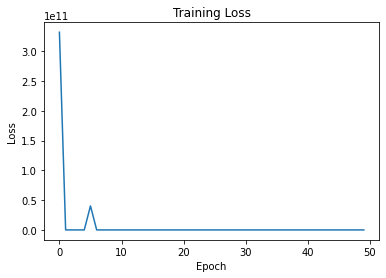

In [26]:
# %% Plot training loss
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [27]:
# %% Evaluation and Visualization of GCN Results
from geopy.distance import geodesic

model.eval()
errors_gcn = []

# Create test DataLoader
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing GCN"):
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.anchor_mask)
        predicted_positions = out.cpu().numpy()
        true_positions = data.y.cpu().numpy()

        # Overwrite anchor nodes' positions with true positions (since anchors are known)
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Calculate estimation errors for unknown nodes using Haversine distance
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:  # Only for unknown nodes
                true_pos = (true_positions[idx][0], true_positions[idx][1])
                pred_pos = (predicted_positions[idx][0], predicted_positions[idx][1])
                error = geodesic(true_pos, pred_pos).meters
                errors_gcn.append(error)

# %% Convert errors to numpy arrays
errors_gcn = np.array(errors_gcn)

# Plot error distributions
plt.figure(figsize=(12, 6), facecolor='white')

plt.hist(errors_gcn, bins=20, alpha=0.7, label='GCN Errors', color='skyblue')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

# Print mean and median errors
print(f"GCN Mean Error: {errors_gcn.mean():.4f} meters, Median Error: {np.median(errors_gcn):.4f} meters")

# %% Visualization: Ground Truth vs. Predicted Positions
sample_data = data_list[0]  # Get a sample test graph for visualization
sample_data = sample_data.to(device)

with torch.no_grad():
    out = model(sample_data.x, sample_data.edge_index, sample_data.edge_attr, sample_data.anchor_mask)
    predicted_positions = out.cpu().numpy()
    true_positions = sample_data.y.cpu().numpy()

# Overwrite anchor nodes' positions with true positions (since anchors are known)
predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

# Plotting
plt.figure(figsize=(12, 6), facecolor='white')

# Ground truth positions
plt.scatter(true_positions[sample_data.unknown_mask.cpu(), 0], true_positions[sample_data.unknown_mask.cpu(), 1], 
            c='blue', label='True Unknown Node Positions', alpha=0.6)

# Predicted positions
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(), 0], predicted_positions[sample_data.unknown_mask.cpu(), 1], 
            c='red', label='Predicted Unknown Node Positions (GCN)', alpha=0.6)

# Anchor positions
plt.scatter(true_positions[sample_data.anchor_mask.cpu(), 0], true_positions[sample_data.anchor_mask.cpu(), 1], 
            c='green', label='Anchor Nodes', marker='^', s=100)

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Comparison of True vs. Predicted Node Positions')
plt.grid(True)
plt.show()


Testing GCN:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)
Testing GCN:   0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: Latitude must be in the [-90; 90] range.